## Proyecto 1 - Aprendizaje Automático
### Integrantes:
- A. Badilla Olivas B80874
- Enrique Vilchez Lizano C18477
- Brandon Mora Umaña 
- Joseph Valverde Kong C18100

In [1]:
# Import necessary modules
import numpy as np

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Data handling
import pandas as pd

# Preprocessing tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Model selection tools
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

# Plots
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# Utils
from typing import Tuple, List
import warnings

# Suppress all warnings
# warnings.filterwarnings("ignore")

In [2]:
def make_grid_search(
    model: object, search_space: dict, X: pd.DataFrame, Y: pd.Series, verbose: int = 1
) -> tuple:
    """
    Perform grid search to find the best hyperparameters for a given model.

    Args:
        model (object): The machine learning model from the sci kit learn library to be used for grid search.
        search_space (dict): The hyperparameter search space.
        X (pd.DataFrame): The input features.
        Y (pd.Series): The target variable.
        verbose (int, optional): Verbosity level. Default is 1.

    Returns:
        tuple: A tuple containing the best score, best parameters, and the results of the grid search.

    """
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=search_space,
        scoring=["accuracy", "precision", "recall", "roc_auc"],
        refit="roc_auc",
        cv=5,
        verbose=verbose,
    )

    grid_search.fit(X, Y)
    results = pd.DataFrame(grid_search.cv_results_)
    return grid_search.best_score_, grid_search.best_params_, results

In [35]:
def fit_and_get_metrics(
    model: object, algorithm: str, X: pd.DataFrame, Y: pd.Series, n_folds: int
) -> Tuple[pd.DataFrame, List[List[float]]]:
    """
    Performs cross validation on a model and gets the metrics mean.

    Args:
        model (object): The machine learning model from the sci kit learn library to be used for cross validation.
        algorithm (str): Name of the algorithm being used.
        X (pd.DataFrame): The input features.
        Y (pd.Series): The target variable.
        n_folds (int): Number of folds for cross validation.

    Returns:
        Tuple[pd.DataFrame, List[List[float]]]: A data frame containing the mean values of accuracies, precisions, recalls, roc_auc_scores, and the confusion matrix.

    """
    # Get cross validation indices
    kf = StratifiedKFold(n_splits=n_folds)

    # Metrics
    accuracies = []
    precisions = []
    recalls = []
    rocs = []
    confusion = []

    # Cross validate
    for iteration, (train_index, test_index) in enumerate(kf.split(X, Y)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model.fit(X_train, Y_train)

        # Get metrics
        y_predicted = model.predict(X_test)
        accuracies.append(accuracy_score(Y_test, y_predicted))
        precisions.append(precision_score(Y_test, y_predicted))
        recalls.append(recall_score(Y_test, y_predicted))
        rocs.append(roc_auc_score(Y_test, y_predicted))
        if iteration == 0:
            confusion = confusion_matrix(Y_test, y_predicted)

    columns = ["Accuracy", "Precision", "Recall", "Roc & Auc"]
    metrics = [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(rocs),
    ]

    dataframe = {"Metric": columns, algorithm: metrics}
    return pd.DataFrame(dataframe), confusion

In [36]:
def plot_metrics(
    metrics: pd.DataFrame,
    algorithm: str,
    title: str = None,
    color: object = None,
):
    """
    Plot metrics as a bar plot.

    Args:
        metrics (pd.DataFrame): Pandas DataFrame with metrics.
        algorithm (str): Name of the algorithm used to getmetrics.
        title (str, optional): Title for the plot.
        colors (object, optional): Colors used for the heat map. Defaults to None.
    """
    """
    # Create the bar plot
    """
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    plt.figure(figsize=(8, 4))
    if color is not None:
        bar_plot = plt.barh(
            metrics["Metric"],
            metrics[algorithm],
            color=color(rescale(metrics[algorithm])),
        )
    else:
        bar_plot = plt.barh(metrics["Metric"], metrics[algorithm])

    # Add a border
    for bar in bar_plot:
        bar.set_edgecolor("black")
        bar.set_linewidth(0.5)

    x_offset = 0.01
    # Add exact values on the bars
    for index, value in enumerate(metrics[algorithm]):
        plt.text(
            value + x_offset, index, f"{value:.4f}", va="center", ha="left", fontsize=8
        )

    # Add labels and title
    plt.xlabel("Value")
    plt.ylabel("Metric")
    if title is not None:
        plt.title(title)
    else:
        plt.title("Model Evaluation Metrics")

    # Increase limits
    plt.xlim(0, max(metrics[algorithm]) * 1.15)

    # Invert y-axis to have the bars ordered top to bottom
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
def plot_confusion_matrix(
    confusion_matrix: List[List[float]],
    labels: List[str] = None,
    title: str = None,
    colors: object = None,
):
    """
    Plots a confusion matrix.

    Args:
        confusion_matrix (List[List[float]]): Confusion matrix.
        labels (List[str], optional): Display labels. Defaults to None (number from 0 to n_classes are chosen).
        title (str, optional): Title for the plot. Defaults to None.
        colors (object, optional): Colors used for the heat map. Defaults to None.
    """
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=labels
    )
    disp.plot(cmap=colors)

    # Display title
    if title is not None:
        disp.ax_.set_title(title)

    plt.show()

In [68]:
def get_general_metrics(algorithms_metrics: List[pd.DataFrame]) -> pd.DataFrame:
    """
    Creates a panda dataframe that contains a table with the information of each metric for each algorithm.
    Columns are the metrics and rows are the algorithms.

    Args:
        algorithms_metrics (List[pd.DataFrame]): A list of data frames containing the metrics for an algorithm.

    Returns:
        pd.Dataframe: The table with the information of each metric for each algorithm.
    """
    for index, algorithm_metrics in enumerate(algorithms_metrics):
        algorithms_metrics[index] = algorithm_metrics.set_index("Metric").T
        # Remove the "Metric" column name
        algorithms_metrics[index].columns.name = None

    return pd.concat(algorithms_metrics).T

In [64]:
def plot_general_metrics(general_metrics: pd.DataFrame):
    """
    Creates a line plot, where each line is a metric, the y axis is the value and the xaxis is the algorithm.

    Args:
        general_metrics (pd.DataFrame): General metrics table.
    """
    plt.figure(figsize=(8, 4))
    general_metrics.T.plot(kind="line", marker="o")
    plt.xlabel("Algorithm")
    plt.ylabel("Metric Value")
    plt.title("General Metrics")
    plt.show()

# Wine Quality Dataset

## Dataset Preparation

In [6]:
# read and explore the dataset
wine_data = pd.read_csv("datasets/winequality_red.csv")

In [7]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
wine_data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [10]:
# Remove rows with empty data on the label
wine_data.dropna(axis=0, subset=["quality"], inplace=True)

# Separate data
y_wine = wine_data["quality"]
X_wine = wine_data.drop(columns=["quality"])
X_wine.describe()

# Modify quality labels to 1 or 0
y_wine = y_wine.apply(lambda x: 1 if x > 6 else 0)
y_wine.value_counts()

# Scale the data
normalizer = StandardScaler()
X_wine_normalized = pd.DataFrame(normalizer.fit_transform(X_wine))

# After we transform the data, we should put back the column names
X_wine_normalized.columns = X_wine.columns.astype(str)

## Logistic Regression

In [11]:
# Parameters selection
search_space_log = {
    "fit_intercept": [True, False],  # Add bias constant or not
    "solver": ["lbfgs", "liblinear", "newton-cholesky", "newton-cg", "sag", "saga"],
    "max_iter": [1, 5, 10, 30, 50, 100],
}

log_classifier = LogisticRegression(random_state=1)
best_log_score, best_log_params, results_log = make_grid_search(
    model=log_classifier, search_space=search_space_log, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/enrique/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/enrique/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [12]:
print("Tuned hyperparameters (best parameters): ", best_log_params)
print("Best score:", best_log_score)

Tuned hyperparameters (best parameters):  {'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
Best score: 0.8835019173273363


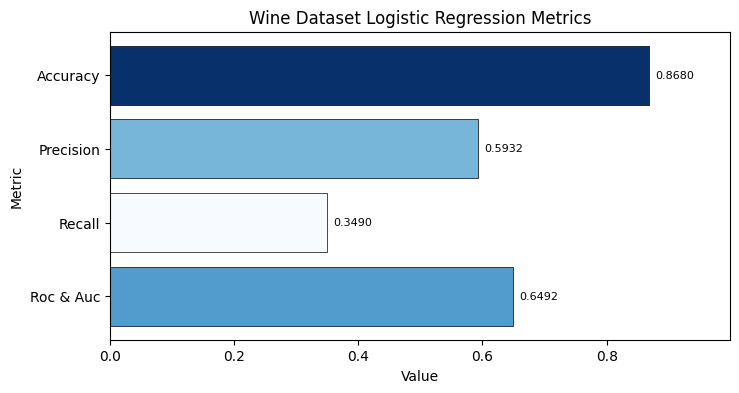

In [46]:
log_classifier = LogisticRegression(random_state=1, **best_log_params)
algorithm_name = "Logistic Regression"
log_metrics, confusion_mat = fit_and_get_metrics(
    model=log_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_metrics(
    metrics=log_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset Logistic Regression Metrics",
    color=plt.cm.Blues,
)

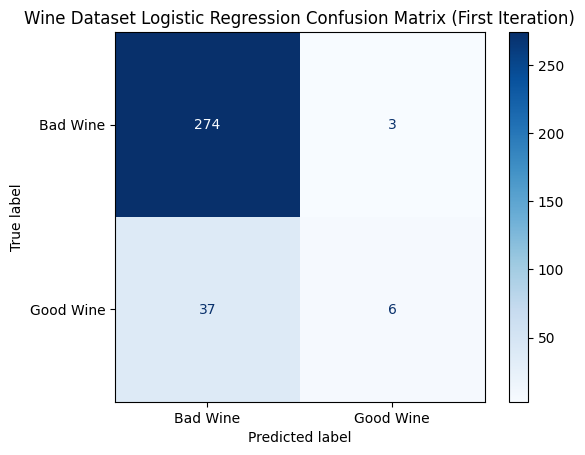

In [14]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset Logistic Regression Confusion Matrix (First Iteration)",
    colors=plt.cm.Blues,
)

## Decision Trees

In [15]:
# Parameters selection
search_space_tree = {
    "criterion": ["gini", "entropy", "log_loss"],  # Loss criteria
    "splitter": ["best", "random"],  # Type of split for the nodes
    "max_depth": [1, 5, 10, 30, 50, 100],  # Maxiumun tree depth
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Minimun number of samples needed to split a node
}

tree_classifier = DecisionTreeClassifier(random_state=1)
best_tree_score, best_tree_params, tree_results = make_grid_search(
    model=tree_classifier, search_space=search_space_tree, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [16]:
print("Tuned hyperparameters (best parameters): ", best_tree_params)
print("Best score :", best_tree_score)

Tuned hyperparameters (best parameters):  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'splitter': 'random'}
Best score : 0.8092821516663609


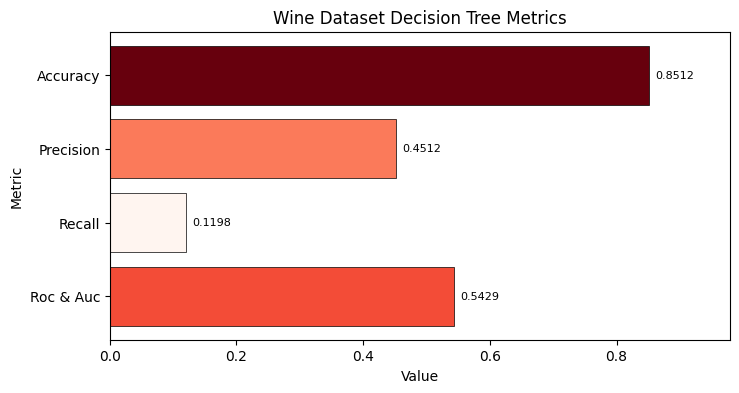

In [45]:
tree_classifier = DecisionTreeClassifier(random_state=1, **best_tree_params)
algorithm_name = "Decision Tree"
tree_metrics, confusion_mat = fit_and_get_metrics(
    model=tree_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_metrics(
    metrics=tree_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset Decision Tree Metrics",
    color=plt.cm.Reds,
)

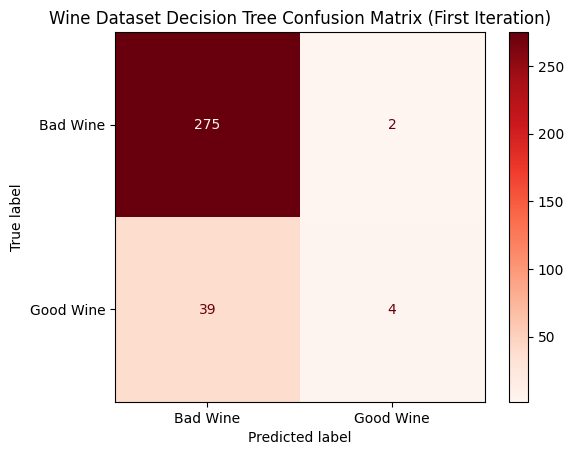

In [40]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset Decision Tree Confusion Matrix (First Iteration)",
    colors=plt.cm.Reds,
)

## KNN

In [19]:
knn_search_space = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}

knn_classifier = KNeighborsClassifier()

best_knn_score, best_knn_params, results_knn = make_grid_search(
    model=knn_classifier, search_space=knn_search_space, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [20]:
print("Tuned hyperparameters (best parameters): ", best_knn_params)
print("Best score :", best_knn_score)

Tuned hyperparameters (best parameters):  {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best score : 0.8255774270724826


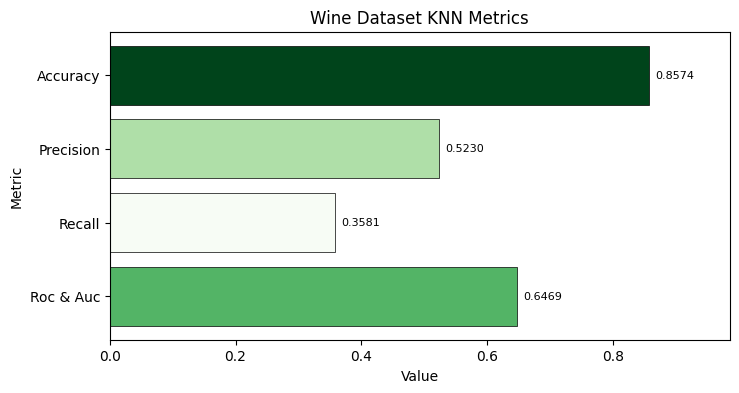

In [44]:
knn_classifier = KNeighborsClassifier(**best_knn_params)
algorithm_name = "Knn"
knn_metrics, confusion_mat = fit_and_get_metrics(
    model=knn_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_metrics(
    metrics=knn_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset KNN Metrics",
    color=plt.cm.Greens,
)

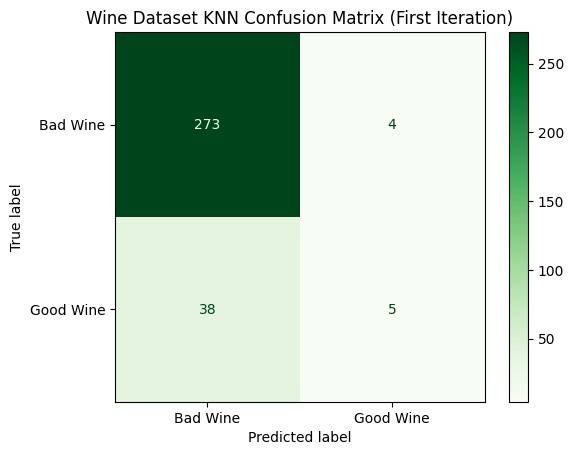

In [22]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset KNN Confusion Matrix (First Iteration)",
    colors=plt.cm.Greens,
)

## Neural Network

In [23]:
# Parameters selection
search_space_mlp = {
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adams"],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "warm_start": [True, False],
    "early_stopping": [True, False],
}

mlp_classifier = MLPClassifier(random_state=1)
best_mlp_score, best_mlp_params, mlp_results = make_grid_search(
    model=mlp_classifier, search_space=search_space_mlp, X=X_wine_normalized, Y=y_wine
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [24]:
print("Tuned hyperparameters (best parameters): ", best_mlp_params)
print("Best score :", best_mlp_score)

Tuned hyperparameters (best parameters):  {'activation': 'identity', 'early_stopping': True, 'learning_rate': 'constant', 'solver': 'lbfgs', 'warm_start': True}
Best score : 0.8790670753742429


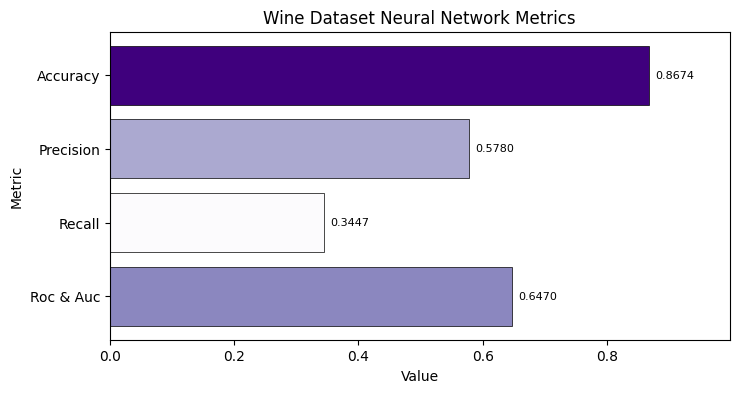

In [43]:
mlp_classifier = MLPClassifier(random_state=1, **best_mlp_params)
algorithm_name = "Neural Network"
mlp_metrics, confusion_mat = fit_and_get_metrics(
    model=mlp_classifier,
    algorithm=algorithm_name,
    X=X_wine_normalized,
    Y=y_wine,
    n_folds=5,
)
plot_metrics(
    metrics=mlp_metrics,
    algorithm=algorithm_name,
    title="Wine Dataset Neural Network Metrics",
    color=plt.cm.Purples,
)

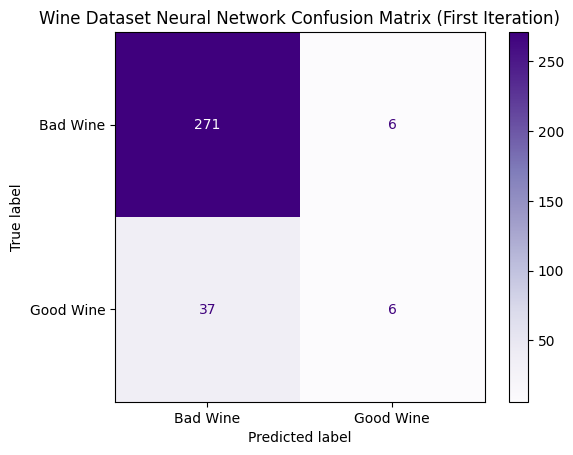

In [26]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Bad Wine", "Good Wine"],
    title="Wine Dataset Neural Network Confusion Matrix (First Iteration)",
    colors=plt.cm.Purples,
)

## General

In [66]:
algorithms_metrics = [log_metrics, knn_metrics, tree_metrics, mlp_metrics]
general_metrics = get_general_metrics(algorithms_metrics)
general_metrics

,Logistic Regression,Knn,Decision Tree,Neural Network
Accuracy,0.868047,0.857418,0.851164,0.867428
Precision,0.593194,0.523044,0.451163,0.578035
Recall,0.349049,0.358140,0.119767,0.344715
Roc & Auc,0.649199,0.646855,0.542899,0.647033


<Figure size 800x400 with 0 Axes>

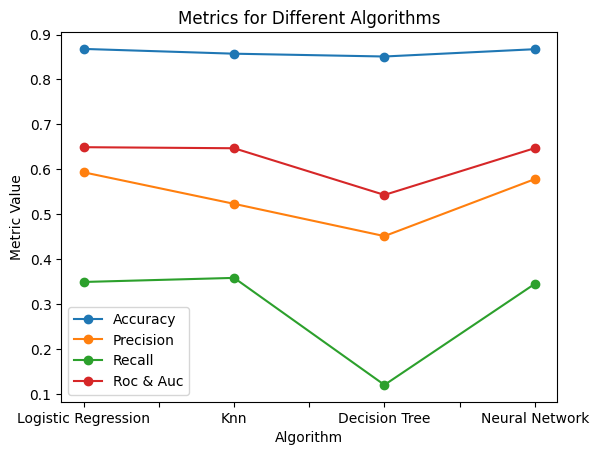

In [67]:
plot_general_metrics(general_metrics=general_metrics)

# Credit Card Dataset

## Dataset Preparation

In [27]:
# Read dataset
credit_card_data = pd.read_csv("datasets/credit_card_approvals.csv")

In [28]:
credit_card_data.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


In [29]:
credit_card_data.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Approved
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000
mean,0.695652,31.514116,4.758725,0.760870,0.763768,2.223406,0.523188,0.427536,2.40000,0.457971,180.547826,1017.385507,0.444928
std,0.460464,11.860245,4.978163,0.426862,0.425074,3.346513,0.499824,0.495080,4.86294,0.498592,173.970323,5210.102598,0.497318
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,1.000000,1.000000,0.165000,0.000000,0.000000,0.00000,0.000000,60.000000,0.000000,0.000000
50%,1.000000,28.460000,2.750000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,160.000000,5.000000,0.000000
75%,1.000000,37.707500,7.207500,1.000000,1.000000,2.625000,1.000000,1.000000,3.00000,1.000000,272.000000,395.500000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.000000,28.500000,1.000000,1.000000,67.00000,1.000000,2000.000000,100000.000000,1.000000


In [30]:
# Remove empty rows
credit_card_data.dropna(axis=0, subset=["Approved"], inplace=True)

# Separate data
y_credit = credit_card_data["Approved"]
X_credit = credit_card_data.drop(columns=["Approved"])

# Get categorical and numerical columns
cat_cols = X_credit.select_dtypes(include="object").columns.tolist()
num_cols = X_credit.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Normalize numerical values and transformm categorical ones
pipeline = ColumnTransformer(
    [
        ("numerical", StandardScaler(), num_cols),
        ("categorical_ordinal", OrdinalEncoder(), cat_cols),
    ]
)

X_credit_normalized = pd.DataFrame(pipeline.fit_transform(X_credit))
X_credit_normalized.columns = num_cols + cat_cols

cat_pipeline = ColumnTransformer(
    [("categorical_minmax", MinMaxScaler(feature_range=(-1, 1)), cat_cols)]
)

X_credit_normalized[cat_cols] = cat_pipeline.fit_transform(
    X_credit_normalized[cat_cols]
)
X_credit_normalized

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Industry,Ethnicity,Citizen
0,0.661438,-0.057723,-0.956613,0.560612,0.556146,-0.291083,0.954650,1.157144,-0.288101,-0.919195,0.123399,-0.195413,0.076923,1.0,-1.0
1,-1.511858,2.291317,-0.060051,0.560612,0.556146,0.244190,0.954650,1.157144,0.740830,-0.919195,-0.791213,-0.087852,0.384615,-0.5,-1.0
2,-1.511858,-0.591826,-0.856102,0.560612,0.556146,-0.216324,0.954650,-0.864196,-0.493887,-0.919195,0.572076,-0.037144,0.384615,-0.5,-1.0
3,0.661438,-0.310853,-0.647038,0.560612,0.556146,0.456505,0.954650,1.157144,0.535044,1.087908,-0.463333,-0.194837,0.076923,1.0,-1.0
4,0.661438,-0.957176,0.174141,0.560612,0.556146,-0.153526,0.954650,-0.864196,-0.493887,-0.919195,-0.348288,-0.195413,0.076923,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.661438,-0.880394,1.070704,-1.783765,-1.798090,-0.291083,-1.047504,-0.864196,-0.493887,-0.919195,0.457031,-0.195413,-0.538462,-0.5,-1.0
686,-1.511858,-0.746235,-0.805846,0.560612,0.556146,-0.066806,-1.047504,1.157144,-0.082314,1.087908,0.111894,-0.119736,-0.384615,1.0,-1.0
687,-1.511858,-0.528544,1.757198,-1.783765,-1.798090,-0.066806,-1.047504,1.157144,-0.288101,1.087908,0.111894,-0.195221,-0.076923,0.0,-1.0
688,0.661438,-1.147023,-0.915403,0.560612,0.556146,-0.652915,-1.047504,-0.864196,-0.493887,-0.919195,0.572076,-0.051358,-0.692308,1.0,-1.0


## Logistic Regression

## Decision Trees

In [31]:
# Parameters selection
search_space_tree = {
    "criterion": ["gini", "entropy", "log_loss"],  # Loss criteria
    "splitter": ["best", "random"],  # Type of split for the nodes
    "max_depth": [1, 5, 10, 30, 50, 100],  # Maxiumun tree depth
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Minimun number of samples needed to split a node
}

tree_classifier = DecisionTreeClassifier(random_state=1)
best_tree_score, best_tree_params, tree_results = make_grid_search(
    model=tree_classifier,
    search_space=search_space_tree,
    X=X_credit_normalized,
    Y=y_credit,
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [32]:
print("Tuned hyperparameters (best parameters): ", best_tree_params)
print("Best score :", best_tree_score)

Tuned hyperparameters (best parameters):  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'splitter': 'random'}
Best score : 0.9050278091748771


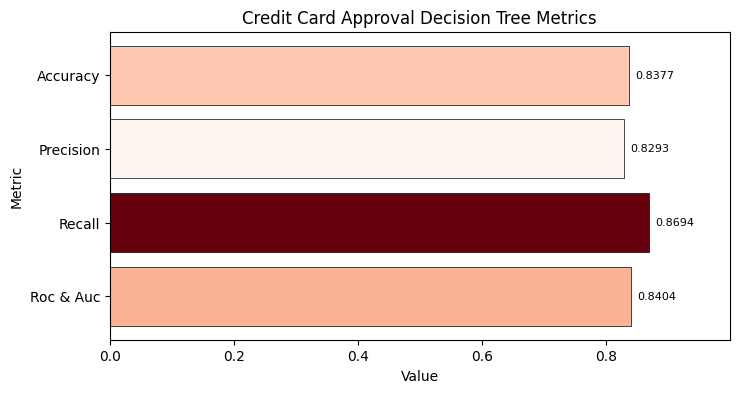

In [33]:
tree_classifier = DecisionTreeClassifier(random_state=1, **best_tree_params)
algorithm_name = "Decision Tree"
tree_metrics, confusion_mat = fit_and_get_metrics(
    model=tree_classifier,
    algorithm="Decision Tree",
    X=X_credit_normalized,
    Y=y_credit,
    n_folds=5,
)
plot_metrics(
    metrics=tree_metrics,
    algorithm=algorithm_name,
    title="Credit Card Approval Decision Tree Metrics",
    color=plt.cm.Reds,
)

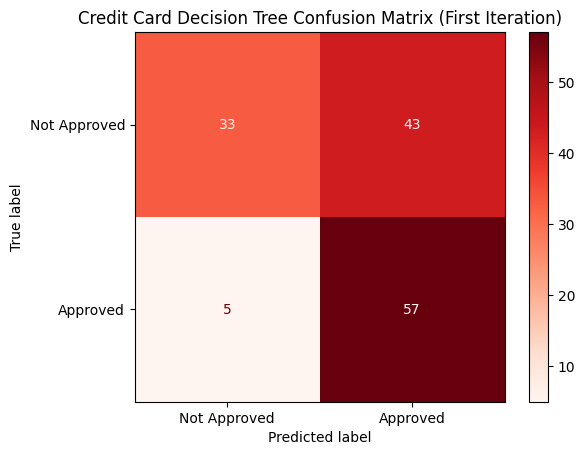

In [34]:
plot_confusion_matrix(
    confusion_matrix=confusion_mat,
    labels=["Not Approved", "Approved"],
    title="Credit Card Decision Tree Confusion Matrix (First Iteration)",
    colors=plt.cm.Reds,
)

## KNN

## Neural Network

## General